In [89]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

(raylet) [2022-10-13 20:36:16,202 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1041592320; capacity: 29394726912. Object creation will fail if spilling is required.


In [90]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0.5

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [91]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


(raylet) [2022-10-13 20:36:26,210 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1040863232; capacity: 29394726912. Object creation will fail if spilling is required.


tensor(0.2070, dtype=torch.float64)

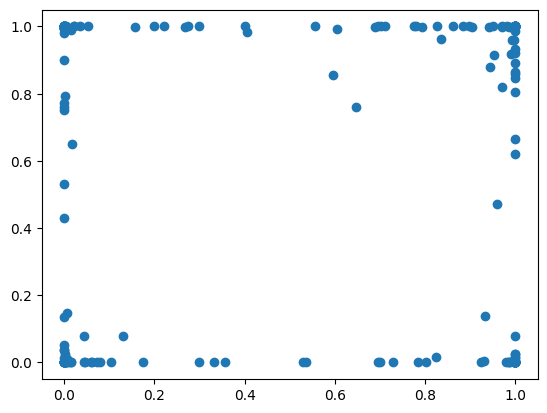

In [92]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [93]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [94]:
################## first step##################

prior=[1,2,3,4,5,6,7]
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lr,ga,lambda1= config["lr"], config["ga"], config["lambda1"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        lambda2=0.002
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
            
            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr": tune.choice([0.8]),
        "ga": tune.choice([0.3,0.1,0.05,0.01]),
        "lambda1": tune.choice([0.03,0.04,0.05])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=20)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,ga,lambda1,lr,iter,total time (s),my_test_BCE_loss
train_model_a964e_00000,TERMINATED,10.224.0.12:3225,0.01,0.05,0.8,1,46.7515,1.5914
train_model_a964e_00001,TERMINATED,10.224.0.12:4272,0.05,0.03,0.8,1,46.7018,1.5806
train_model_a964e_00002,TERMINATED,10.224.0.12:4289,0.01,0.03,0.8,1,46.8469,1.58794
train_model_a964e_00003,TERMINATED,10.224.0.12:4293,0.01,0.05,0.8,1,34.1496,1.5914
train_model_a964e_00004,TERMINATED,10.224.0.12:4300,0.3,0.04,0.8,1,36.9004,1.61858
train_model_a964e_00005,TERMINATED,10.224.0.12:4306,0.01,0.04,0.8,1,34.5527,1.55914
train_model_a964e_00006,TERMINATED,10.224.0.12:4338,0.05,0.05,0.8,1,35.8784,1.59943
train_model_a964e_00007,TERMINATED,10.224.0.12:4343,0.1,0.03,0.8,1,46.2206,1.57214
train_model_a964e_00008,TERMINATED,10.224.0.12:4340,0.05,0.05,0.8,1,45.9318,1.59943
train_model_a964e_00009,TERMINATED,10.224.0.12:4349,0.01,0.05,0.8,1,34.4191,1.5914


(raylet) [2022-10-13 20:36:36,249 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1038434304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:36:46,292 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1037819904; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:36:56,352 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1037488128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:37:06,416 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1037099008; capacity: 29394726912. Object creation will fa

Result for train_model_a964e_00016:
  date: 2022-10-13_20-37-12
  done: false
  experiment_id: 58b6453aff274fc48e07ca69578f3c38
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5879378616809845
  node_ip: 10.224.0.12
  pid: 4378
  time_since_restore: 32.66100811958313
  time_this_iter_s: 32.66100811958313
  time_total_s: 32.66100811958313
  timestamp: 1665664632
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a964e_00016
  warmup_time: 0.014268636703491211
  
Result for train_model_a964e_00016:
  date: 2022-10-13_20-37-12
  done: true
  experiment_id: 58b6453aff274fc48e07ca69578f3c38
  experiment_tag: 16_ga=0.0100,lambda1=0.0300,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5879378616809845
  node_ip: 10.224.0.12
  pid: 4378
  time_since_restore: 32.66100811958313
  time_this_iter_s: 32.66100811958313
  time_total_s: 32.66100811958313
  timestamp: 1665664632
  timesteps_since_restore: 0


Result for train_model_a964e_00004:
  date: 2022-10-13_20-37-15
  done: false
  experiment_id: 8f3c8847f80c448ea3a0703601f3dc09
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6185794651508332
  node_ip: 10.224.0.12
  pid: 4300
  time_since_restore: 36.900365114212036
  time_this_iter_s: 36.900365114212036
  time_total_s: 36.900365114212036
  timestamp: 1665664635
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a964e_00004
  warmup_time: 0.014341354370117188
  
Result for train_model_a964e_00004:
  date: 2022-10-13_20-37-15
  done: true
  experiment_id: 8f3c8847f80c448ea3a0703601f3dc09
  experiment_tag: 4_ga=0.3000,lambda1=0.0400,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6185794651508332
  node_ip: 10.224.0.12
  pid: 4300
  time_since_restore: 36.900365114212036
  time_this_iter_s: 36.900365114212036
  time_total_s: 36.900365114212036
  timestamp: 1665664635
  timesteps_since_restor

(raylet) [2022-10-13 20:37:16,463 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1035763712; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_a964e_00006:
  date: 2022-10-13_20-37-16
  done: false
  experiment_id: b1c7b0694d2743aab0db2b03bc6378a7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5994295954704285
  node_ip: 10.224.0.12
  pid: 4338
  time_since_restore: 35.87841081619263
  time_this_iter_s: 35.87841081619263
  time_total_s: 35.87841081619263
  timestamp: 1665664636
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a964e_00006
  warmup_time: 0.02754688262939453
  
Result for train_model_a964e_00006:
  date: 2022-10-13_20-37-16
  done: true
  experiment_id: b1c7b0694d2743aab0db2b03bc6378a7
  experiment_tag: 6_ga=0.0500,lambda1=0.0500,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5994295954704285
  node_ip: 10.224.0.12
  pid: 4338
  time_since_restore: 35.87841081619263
  time_this_iter_s: 35.87841081619263
  time_total_s: 35.87841081619263
  timestamp: 1665664636
  timesteps_since_restore: 0
  

(raylet) [2022-10-13 20:37:26,477 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1034858496; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_a964e_00007:
  date: 2022-10-13_20-37-26
  done: false
  experiment_id: b45d3da5967140e59cb9dc0338a10c7f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5721421122550965
  node_ip: 10.224.0.12
  pid: 4343
  time_since_restore: 46.2205548286438
  time_this_iter_s: 46.2205548286438
  time_total_s: 46.2205548286438
  timestamp: 1665664646
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a964e_00007
  warmup_time: 0.038663387298583984
  
Result for train_model_a964e_00007:
  date: 2022-10-13_20-37-26
  done: true
  experiment_id: b45d3da5967140e59cb9dc0338a10c7f
  experiment_tag: 7_ga=0.1000,lambda1=0.0300,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5721421122550965
  node_ip: 10.224.0.12
  pid: 4343
  time_since_restore: 46.2205548286438
  time_this_iter_s: 46.2205548286438
  time_total_s: 46.2205548286438
  timestamp: 1665664646
  timesteps_since_restore: 0
  train

2022-10-13 20:37:28,896	INFO tune.py:758 -- Total run time: 59.13 seconds (58.97 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
a964e_00000          1.591398         46.751480  True            None   
a964e_00001          1.580604         46.701813  True            None   
a964e_00002          1.587938         46.846942  True            None   
a964e_00003          1.591398         34.149566  True            None   
a964e_00004          1.618579         36.900365  True            None   
a964e_00005          1.559136         34.552720  True            None   
a964e_00006          1.599430         35.878411  True            None   
a964e_00007          1.572142         46.220555  True            None   
a964e_00008          1.599430         45.931844  True            None   
a964e_00009          1.591398         34.419126  True            None   
a964e_00010          1.608496         45.401703  True            N

(raylet) [2022-10-13 20:37:36,485 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1033486336; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:37:46,493 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1032765440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:37:56,508 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1032024064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:38:06,531 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1030983680; capacity: 29394726912. Object creation will fa

In [95]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.5591358423233033


{'lr': 0.8, 'ga': 0.01, 'lambda1': 0.04}

(raylet) [2022-10-13 20:38:26,544 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1028325376; capacity: 29394726912. Object creation will fail if spilling is required.


In [96]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lr,ga=final_lambda["lambda1"],final_lambda["lr"],final_lambda["ga"]
lambda2=0.002
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.2213, grad_fn=<AddBackward0>)

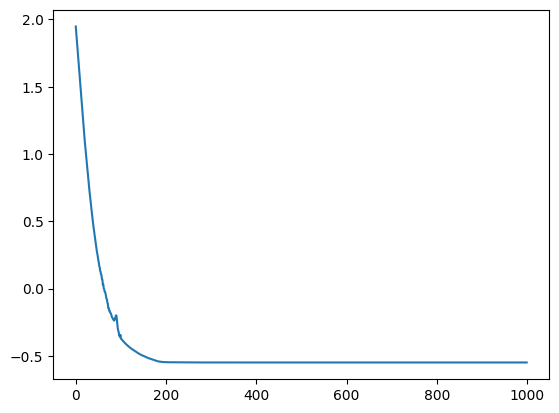

In [97]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [98]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x2)[0]).detach().squeeze()
BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss

BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(2.1946)

tensor(0.1138)

tensor(0.0113)

tensor(2.0695)

(raylet) [2022-10-13 20:38:36,560 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1027444736; capacity: 29394726912. Object creation will fail if spilling is required.


In [99]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[73,  3],
       [ 3, 81]])

array([[85,  0],
       [ 0, 75]])

array([[68,  0],
       [ 1, 91]])

(raylet) [2022-10-13 20:38:46,567 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1025961984; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:38:56,574 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1025626112; capacity: 29394726912. Object creation will fail if spilling is required.


In [100]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,ga,lr= config["lambda1"], config["lambda2"],config["eta"],config["ga"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
            
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

        test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.002,0.003]),
        "lr": tune.choice([0.8]),
        "ga": tune.choice([0.3]),
        "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75])
    }


    result = tune.run(
        train_model,  
        config=config,
        num_samples=200)
    
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_019ec_00000,TERMINATED,10.224.0.12:8640,0.75,0.3,0.05,0.002,0.8,1,65.0085,1.8816
train_model_019ec_00001,TERMINATED,10.224.0.12:8785,0.15,0.3,0.01,0.002,0.8,1,46.7566,2.53583
train_model_019ec_00002,TERMINATED,10.224.0.12:8787,0.09,0.3,0.05,0.003,0.8,1,49.3912,1.91572
train_model_019ec_00003,TERMINATED,10.224.0.12:8789,0.25,0.3,0.02,0.002,0.8,1,48.916,2.16622
train_model_019ec_00004,TERMINATED,10.224.0.12:8792,0.06,0.3,0.04,0.002,0.8,1,68.7682,2.12798
train_model_019ec_00005,TERMINATED,10.224.0.12:8795,0.17,0.3,0.01,0.003,0.8,1,67.2672,2.37825
train_model_019ec_00006,TERMINATED,10.224.0.12:8797,0.55,0.3,0.01,0.003,0.8,1,49.3875,2.2492
train_model_019ec_00007,TERMINATED,10.224.0.12:8799,0.45,0.3,0.03,0.002,0.8,1,65.7272,1.87264
train_model_019ec_00008,TERMINATED,10.224.0.12:8801,0.17,0.3,0.05,0.002,0.8,1,46.5952,1.93065
train_model_019ec_00009,TERMINATED,10.224.0.12:8803,0.06,0.3,0.03,0.003,0.8,1,69.7464,2.08103


(raylet) [2022-10-13 20:39:06,645 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1023721472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:39:16,732 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1023045632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:39:26,792 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1021853696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:39:36,889 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1021652992; capacity: 29394726912. Object creation will fa

Result for train_model_019ec_00000:
  date: 2022-10-13_20-40-07
  done: false
  experiment_id: 7d73df7cb9384bad8afc817006e85b5f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8815997958183288
  node_ip: 10.224.0.12
  pid: 8640
  time_since_restore: 65.00848031044006
  time_this_iter_s: 65.00848031044006
  time_total_s: 65.00848031044006
  timestamp: 1665664807
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00000
  warmup_time: 0.005113363265991211
  
Result for train_model_019ec_00019:
  date: 2022-10-13_20-40-25
  done: false
  experiment_id: a0e7c4ab2f5d4763bf4cde4ad411e96a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.452263331413269
  node_ip: 10.224.0.12
  pid: 9276
  time_since_restore: 64.55572724342346
  time_this_iter_s: 64.55572724342346
  time_total_s: 64.55572724342346
  timestamp: 1665664825
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00019
  warmup

Result for train_model_019ec_00002:
  date: 2022-10-13_20-39-58
  done: true
  experiment_id: 436cd7b0eca641dca322368ef6834050
  experiment_tag: 2_eta=0.0900,ga=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9157163500785828
  node_ip: 10.224.0.12
  pid: 8787
  time_since_restore: 49.39119267463684
  time_this_iter_s: 49.39119267463684
  time_total_s: 49.39119267463684
  timestamp: 1665664798
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00002
  warmup_time: 0.0343317985534668
  
Result for train_model_019ec_00012:
  date: 2022-10-13_20-40-15
  done: true
  experiment_id: f299919a62ea424d995320f8b5e44f91
  experiment_tag: 12_eta=0.7500,ga=0.3000,lambda1=0.0100,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.2133089900016785
  node_ip: 10.224.0.12
  pid: 8811
  time_since_restore: 65.46936750411987
  time_this_iter_s: 6

Result for train_model_019ec_00017:
  date: 2022-10-13_20-39-57
  done: true
  experiment_id: 49efea04163a499baa435369171a610d
  experiment_tag: 17_eta=0.4500,ga=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8064111471176147
  node_ip: 10.224.0.12
  pid: 8821
  time_since_restore: 47.497883796691895
  time_this_iter_s: 47.497883796691895
  time_total_s: 47.497883796691895
  timestamp: 1665664797
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00017
  warmup_time: 0.017232894897460938
  
Result for train_model_019ec_00021:
  date: 2022-10-13_20-40-31
  done: false
  experiment_id: a4d4212cadfb423e83c4b587d203bfbf
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.201268184185028
  node_ip: 10.224.0.12
  pid: 9447
  time_since_restore: 58.21256232261658
  time_this_iter_s: 58.21256232261658
  time_total_s: 58.21256232261658
  timestamp: 1665664831
 

(raylet) [2022-10-13 20:40:37,200 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1016623104; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00024:
  date: 2022-10-13_20-40-37
  done: false
  experiment_id: 8f570e80c10f4eb09b141c1e85f36e3e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.810338544845581
  node_ip: 10.224.0.12
  pid: 9643
  time_since_restore: 44.789823055267334
  time_this_iter_s: 44.789823055267334
  time_total_s: 44.789823055267334
  timestamp: 1665664837
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00024
  warmup_time: 0.01605367660522461
  
Result for train_model_019ec_00024:
  date: 2022-10-13_20-40-37
  done: true
  experiment_id: 8f570e80c10f4eb09b141c1e85f36e3e
  experiment_tag: 24_eta=0.4500,ga=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.810338544845581
  node_ip: 10.224.0.12
  pid: 9643
  time_since_restore: 44.789823055267334
  time_this_iter_s: 44.789823055267334
  time_total_s: 44.789823055267334
  timestamp: 1665664837


(raylet) [2022-10-13 20:40:47,249 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1015787520; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00028:
  date: 2022-10-13_20-40-54
  done: false
  experiment_id: 28f22fccf93941aa9cd7a86cafa8d6c7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.2042776346206665
  node_ip: 10.224.0.12
  pid: 9943
  time_since_restore: 38.934510231018066
  time_this_iter_s: 38.934510231018066
  time_total_s: 38.934510231018066
  timestamp: 1665664854
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00028
  warmup_time: 0.02930736541748047
  
Result for train_model_019ec_00028:
  date: 2022-10-13_20-40-54
  done: true
  experiment_id: 28f22fccf93941aa9cd7a86cafa8d6c7
  experiment_tag: 28_eta=0.1200,ga=0.3000,lambda1=0.0200,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.2042776346206665
  node_ip: 10.224.0.12
  pid: 9943
  time_since_restore: 38.934510231018066
  time_this_iter_s: 38.934510231018066
  time_total_s: 38.934510231018066
  timestamp: 166566485

(raylet) [2022-10-13 20:40:57,304 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1015480320; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00029:
  date: 2022-10-13_20-40-59
  done: false
  experiment_id: 5d5b6652daa641d6ba5eaabe36519868
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7681407570838927
  node_ip: 10.224.0.12
  pid: 9984
  time_since_restore: 38.77229595184326
  time_this_iter_s: 38.77229595184326
  time_total_s: 38.77229595184326
  timestamp: 1665664859
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00029
  warmup_time: 0.02427983283996582
  
Result for train_model_019ec_00029:
  date: 2022-10-13_20-40-59
  done: true
  experiment_id: 5d5b6652daa641d6ba5eaabe36519868
  experiment_tag: 29_eta=0.4500,ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7681407570838927
  node_ip: 10.224.0.12
  pid: 9984
  time_since_restore: 38.77229595184326
  time_this_iter_s: 38.77229595184326
  time_total_s: 38.77229595184326
  timestamp: 1665664859
  ti

Result for train_model_019ec_00040:
  date: 2022-10-13_20-41-05
  done: true
  experiment_id: a13ea6e39298408188ea84e8035652ac
  experiment_tag: 40_eta=0.4500,ga=0.3000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8726416230201721
  node_ip: 10.224.0.12
  pid: 8797
  time_since_restore: 34.16063928604126
  time_this_iter_s: 34.16063928604126
  time_total_s: 34.16063928604126
  timestamp: 1665664865
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00040
  warmup_time: 0.01823568344116211
  
Result for train_model_019ec_00033:
  date: 2022-10-13_20-41-05
  done: false
  experiment_id: 8d916265037c485bab13608e7ce3b23e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.841272234916687
  node_ip: 10.224.0.12
  pid: 8785
  time_since_restore: 34.886332511901855
  time_this_iter_s: 34.886332511901855
  time_total_s: 34.886332511901855
  timestamp: 1665664865
  

(raylet) [2022-10-13 20:41:07,323 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1014685696; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00051:
  date: 2022-10-13_20-41-07
  done: false
  experiment_id: 2352b22fd04b48158e07392229b5e06b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.7872279405593874
  node_ip: 10.224.0.12
  pid: 8813
  time_since_restore: 36.02089023590088
  time_this_iter_s: 36.02089023590088
  time_total_s: 36.02089023590088
  timestamp: 1665664867
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00051
  warmup_time: 0.024360179901123047
  
Result for train_model_019ec_00051:
  date: 2022-10-13_20-41-07
  done: true
  experiment_id: 2352b22fd04b48158e07392229b5e06b
  experiment_tag: 51_eta=0.0600,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.7872279405593874
  node_ip: 10.224.0.12
  pid: 8813
  time_since_restore: 36.02089023590088
  time_this_iter_s: 36.02089023590088
  time_total_s: 36.02089023590088
  timestamp: 1665664867
  t

Result for train_model_019ec_00052:
  date: 2022-10-13_20-41-09
  done: true
  experiment_id: a4d4212cadfb423e83c4b587d203bfbf
  experiment_tag: 52_eta=0.1200,ga=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.887338137626648
  node_ip: 10.224.0.12
  pid: 9447
  time_since_restore: 38.309741258621216
  time_this_iter_s: 38.309741258621216
  time_total_s: 38.309741258621216
  timestamp: 1665664869
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00052
  warmup_time: 0.017691373825073242
  
Result for train_model_019ec_00047:
  date: 2022-10-13_20-41-10
  done: false
  experiment_id: a0e7c4ab2f5d4763bf4cde4ad411e96a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.2492045998573302
  node_ip: 10.224.0.12
  pid: 9276
  time_since_restore: 38.83675932884216
  time_this_iter_s: 38.83675932884216
  time_total_s: 38.83675932884216
  timestamp: 1665664870
 

(raylet) [2022-10-13 20:41:17,372 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1013915648; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00057:
  date: 2022-10-13_20-41-19
  done: false
  experiment_id: c45fea74b45f47dd896bca50fcd082ce
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0865330040454864
  node_ip: 10.224.0.12
  pid: 9682
  time_since_restore: 33.14459753036499
  time_this_iter_s: 33.14459753036499
  time_total_s: 33.14459753036499
  timestamp: 1665664879
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00057
  warmup_time: 0.006421804428100586
  
Result for train_model_019ec_00057:
  date: 2022-10-13_20-41-19
  done: true
  experiment_id: c45fea74b45f47dd896bca50fcd082ce
  experiment_tag: 57_eta=0.0600,ga=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0865330040454864
  node_ip: 10.224.0.12
  pid: 9682
  time_since_restore: 33.14459753036499
  time_this_iter_s: 33.14459753036499
  time_total_s: 33.14459753036499
  timestamp: 1665664879
  t

(raylet) [2022-10-13 20:41:27,396 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1013301248; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00063:
  date: 2022-10-13_20-41-32
  done: false
  experiment_id: 500bf2f88f5b48f0849c5378e30f1d05
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7726449966430664
  node_ip: 10.224.0.12
  pid: 8789
  time_since_restore: 29.339694499969482
  time_this_iter_s: 29.339694499969482
  time_total_s: 29.339694499969482
  timestamp: 1665664892
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00063
  warmup_time: 0.015277385711669922
  
Result for train_model_019ec_00063:
  date: 2022-10-13_20-41-32
  done: true
  experiment_id: 500bf2f88f5b48f0849c5378e30f1d05
  experiment_tag: 63_eta=0.3500,ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7726449966430664
  node_ip: 10.224.0.12
  pid: 8789
  time_since_restore: 29.339694499969482
  time_this_iter_s: 29.339694499969482
  time_total_s: 29.339694499969482
  timestamp: 16656648

Result for train_model_019ec_00070:
  date: 2022-10-13_20-41-35
  done: false
  experiment_id: e10c3c7e7403474f896d2a459f30afe8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.7099602699279783
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 30.10226607322693
  time_this_iter_s: 30.10226607322693
  time_total_s: 30.10226607322693
  timestamp: 1665664895
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00070
  warmup_time: 0.007108211517333984
  
Result for train_model_019ec_00070:
  date: 2022-10-13_20-41-35
  done: true
  experiment_id: e10c3c7e7403474f896d2a459f30afe8
  experiment_tag: 70_eta=0.0900,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.7099602699279783
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 30.10226607322693
  time_this_iter_s: 30.10226607322693
  time_total_s: 30.10226607322693
  timestamp: 1665664895
 

(raylet) [2022-10-13 20:41:37,442 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1012588544; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00072:
  date: 2022-10-13_20-41-38
  done: false
  experiment_id: f299919a62ea424d995320f8b5e44f91
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.4270538568496702
  node_ip: 10.224.0.12
  pid: 8811
  time_since_restore: 31.845991849899292
  time_this_iter_s: 31.845991849899292
  time_total_s: 31.845991849899292
  timestamp: 1665664898
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00072
  warmup_time: 0.013948678970336914
  
Result for train_model_019ec_00072:
  date: 2022-10-13_20-41-38
  done: true
  experiment_id: f299919a62ea424d995320f8b5e44f91
  experiment_tag: 72_eta=0.2500,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.4270538568496702
  node_ip: 10.224.0.12
  pid: 8811
  time_since_restore: 31.845991849899292
  time_this_iter_s: 31.845991849899292
  time_total_s: 31.845991849899292
  timestamp: 16656648

Result for train_model_019ec_00080:
  date: 2022-10-13_20-41-41
  done: false
  experiment_id: bbe84fe2b45d475e96fc01b22ce7cdfd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8531354546546936
  node_ip: 10.224.0.12
  pid: 8807
  time_since_restore: 32.655351877212524
  time_this_iter_s: 32.655351877212524
  time_total_s: 32.655351877212524
  timestamp: 1665664901
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00080
  warmup_time: 0.01587080955505371
  
Result for train_model_019ec_00080:
  date: 2022-10-13_20-41-41
  done: true
  experiment_id: bbe84fe2b45d475e96fc01b22ce7cdfd
  experiment_tag: 80_eta=0.1500,ga=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8531354546546936
  node_ip: 10.224.0.12
  pid: 8807
  time_since_restore: 32.655351877212524
  time_this_iter_s: 32.655351877212524
  time_total_s: 32.655351877212524
  timestamp: 166566490

(raylet) [2022-10-13 20:41:47,470 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1011953664; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00088:
  date: 2022-10-13_20-41-47
  done: false
  experiment_id: 3710b77446304e088b08beef8f1339c4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.612785446643829
  node_ip: 10.224.0.12
  pid: 9567
  time_since_restore: 30.885489463806152
  time_this_iter_s: 30.885489463806152
  time_total_s: 30.885489463806152
  timestamp: 1665664907
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00088
  warmup_time: 0.018831968307495117
  
Result for train_model_019ec_00088:
  date: 2022-10-13_20-41-47
  done: true
  experiment_id: 3710b77446304e088b08beef8f1339c4
  experiment_tag: 88_eta=0.1200,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.612785446643829
  node_ip: 10.224.0.12
  pid: 9567
  time_since_restore: 30.885489463806152
  time_this_iter_s: 30.885489463806152
  time_total_s: 30.885489463806152
  timestamp: 1665664907

(raylet) [2022-10-13 20:41:57,510 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1011474432; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00092:
  date: 2022-10-13_20-41-57
  done: false
  experiment_id: d6dda41bb72348d7aa054fa00d573f7f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9887246191501617
  node_ip: 10.224.0.12
  pid: 9841
  time_since_restore: 30.75192618370056
  time_this_iter_s: 30.75192618370056
  time_total_s: 30.75192618370056
  timestamp: 1665664917
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00092
  warmup_time: 0.012697219848632812
  
Result for train_model_019ec_00092:
  date: 2022-10-13_20-41-57
  done: true
  experiment_id: d6dda41bb72348d7aa054fa00d573f7f
  experiment_tag: 92_eta=0.1700,ga=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9887246191501617
  node_ip: 10.224.0.12
  pid: 9841
  time_since_restore: 30.75192618370056
  time_this_iter_s: 30.75192618370056
  time_total_s: 30.75192618370056
  timestamp: 1665664917
  t

Result for train_model_019ec_00099:
  date: 2022-10-13_20-42-05
  done: false
  experiment_id: 775f3b48e2664944ad0f3031119dee86
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.825088131427765
  node_ip: 10.224.0.12
  pid: 10028
  time_since_restore: 31.14324140548706
  time_this_iter_s: 31.14324140548706
  time_total_s: 31.14324140548706
  timestamp: 1665664925
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00099
  warmup_time: 0.013215065002441406
  
Result for train_model_019ec_00099:
  date: 2022-10-13_20-42-05
  done: true
  experiment_id: 775f3b48e2664944ad0f3031119dee86
  experiment_tag: 99_eta=0.2500,ga=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.825088131427765
  node_ip: 10.224.0.12
  pid: 10028
  time_since_restore: 31.14324140548706
  time_this_iter_s: 31.14324140548706
  time_total_s: 31.14324140548706
  timestamp: 1665664925
  t

(raylet) [2022-10-13 20:42:07,561 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1010831360; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00104:
  date: 2022-10-13_20-42-08
  done: false
  experiment_id: a13ea6e39298408188ea84e8035652ac
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8075147986412048
  node_ip: 10.224.0.12
  pid: 8797
  time_since_restore: 32.086076498031616
  time_this_iter_s: 32.086076498031616
  time_total_s: 32.086076498031616
  timestamp: 1665664928
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00104
  warmup_time: 0.01823568344116211
  
Result for train_model_019ec_00104:
  date: 2022-10-13_20-42-08
  done: true
  experiment_id: a13ea6e39298408188ea84e8035652ac
  experiment_tag: 104_eta=0.3500,ga=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8075147986412048
  node_ip: 10.224.0.12
  pid: 8797
  time_since_restore: 32.086076498031616
  time_this_iter_s: 32.086076498031616
  time_total_s: 32.086076498031616
  timestamp: 16656649

Result for train_model_019ec_00112:
  date: 2022-10-13_20-42-11
  done: false
  experiment_id: 293cdfb908694076993a64ba10f2b27e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1602032661437987
  node_ip: 10.224.0.12
  pid: 8819
  time_since_restore: 32.398069858551025
  time_this_iter_s: 32.398069858551025
  time_total_s: 32.398069858551025
  timestamp: 1665664931
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00112
  warmup_time: 0.02763509750366211
  
Result for train_model_019ec_00112:
  date: 2022-10-13_20-42-11
  done: true
  experiment_id: 293cdfb908694076993a64ba10f2b27e
  experiment_tag: 112_eta=0.0900,ga=0.3000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1602032661437987
  node_ip: 10.224.0.12
  pid: 8819
  time_since_restore: 32.398069858551025
  time_this_iter_s: 32.398069858551025
  time_total_s: 32.398069858551025
  timestamp: 16656649

Result for train_model_019ec_00119:
  date: 2022-10-13_20-42-17
  done: false
  experiment_id: 0ab7910a58b84f7b8d5cd6a5a683e7cd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.612785446643829
  node_ip: 10.224.0.12
  pid: 9356
  time_since_restore: 32.001296281814575
  time_this_iter_s: 32.001296281814575
  time_total_s: 32.001296281814575
  timestamp: 1665664937
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00119
  warmup_time: 0.023510456085205078
  
Result for train_model_019ec_00119:
  date: 2022-10-13_20-42-17
  done: true
  experiment_id: 0ab7910a58b84f7b8d5cd6a5a683e7cd
  experiment_tag: 119_eta=0.1200,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.612785446643829
  node_ip: 10.224.0.12
  pid: 9356
  time_since_restore: 32.001296281814575
  time_this_iter_s: 32.001296281814575
  time_total_s: 32.001296281814575
  timestamp: 166566493

(raylet) [2022-10-13 20:42:17,621 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1010036736; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00120:
  date: 2022-10-13_20-42-20
  done: false
  experiment_id: 3710b77446304e088b08beef8f1339c4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1144514203071596
  node_ip: 10.224.0.12
  pid: 9567
  time_since_restore: 32.89934587478638
  time_this_iter_s: 32.89934587478638
  time_total_s: 32.89934587478638
  timestamp: 1665664940
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00120
  warmup_time: 0.018831968307495117
  
Result for train_model_019ec_00120:
  date: 2022-10-13_20-42-20
  done: true
  experiment_id: 3710b77446304e088b08beef8f1339c4
  experiment_tag: 120_eta=0.3500,ga=0.3000,lambda1=0.0200,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1144514203071596
  node_ip: 10.224.0.12
  pid: 9567
  time_since_restore: 32.89934587478638
  time_this_iter_s: 32.89934587478638
  time_total_s: 32.89934587478638
  timestamp: 1665664940
  

(raylet) [2022-10-13 20:42:27,671 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1009532928; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00124:
  date: 2022-10-13_20-42-30
  done: false
  experiment_id: d27f61d0b4b84e8d825717be8a7470bf
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1418580055236816
  node_ip: 10.224.0.12
  pid: 9740
  time_since_restore: 31.740063905715942
  time_this_iter_s: 31.740063905715942
  time_total_s: 31.740063905715942
  timestamp: 1665664950
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00124
  warmup_time: 0.016160964965820312
  
Result for train_model_019ec_00124:
  date: 2022-10-13_20-42-30
  done: true
  experiment_id: d27f61d0b4b84e8d825717be8a7470bf
  experiment_tag: 124_eta=0.1700,ga=0.3000,lambda1=0.0200,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1418580055236816
  node_ip: 10.224.0.12
  pid: 9740
  time_since_restore: 31.740063905715942
  time_this_iter_s: 31.740063905715942
  time_total_s: 31.740063905715942
  timestamp: 1665664

Result for train_model_019ec_00133:
  date: 2022-10-13_20-42-35
  done: false
  experiment_id: e10c3c7e7403474f896d2a459f30afe8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8531354546546936
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 29.748935222625732
  time_this_iter_s: 29.748935222625732
  time_total_s: 29.748935222625732
  timestamp: 1665664955
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00133
  warmup_time: 0.007108211517333984
  
Result for train_model_019ec_00133:
  date: 2022-10-13_20-42-35
  done: true
  experiment_id: e10c3c7e7403474f896d2a459f30afe8
  experiment_tag: 133_eta=0.1500,ga=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8531354546546936
  node_ip: 10.224.0.12
  pid: 10218
  time_since_restore: 29.748935222625732
  time_this_iter_s: 29.748935222625732
  time_total_s: 29.748935222625732
  timestamp: 16656

(raylet) [2022-10-13 20:42:37,736 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1009012736; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00136:
  date: 2022-10-13_20-42-39
  done: false
  experiment_id: f299919a62ea424d995320f8b5e44f91
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.3782530069351195
  node_ip: 10.224.0.12
  pid: 8811
  time_since_restore: 29.965341091156006
  time_this_iter_s: 29.965341091156006
  time_total_s: 29.965341091156006
  timestamp: 1665664959
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00136
  warmup_time: 0.013948678970336914
  
Result for train_model_019ec_00136:
  date: 2022-10-13_20-42-39
  done: true
  experiment_id: f299919a62ea424d995320f8b5e44f91
  experiment_tag: 136_eta=0.1700,ga=0.3000,lambda1=0.0100,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.3782530069351195
  node_ip: 10.224.0.12
  pid: 8811
  time_since_restore: 29.965341091156006
  time_this_iter_s: 29.965341091156006
  time_total_s: 29.965341091156006
  timestamp: 1665664

Result for train_model_019ec_00144:
  date: 2022-10-13_20-42-43
  done: false
  experiment_id: cffbe11253194e9b91e67ae654a414d2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0865330040454864
  node_ip: 10.224.0.12
  pid: 9530
  time_since_restore: 31.050821781158447
  time_this_iter_s: 31.050821781158447
  time_total_s: 31.050821781158447
  timestamp: 1665664963
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00144
  warmup_time: 0.03285717964172363
  
Result for train_model_019ec_00144:
  date: 2022-10-13_20-42-43
  done: true
  experiment_id: cffbe11253194e9b91e67ae654a414d2
  experiment_tag: 144_eta=0.0600,ga=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0865330040454864
  node_ip: 10.224.0.12
  pid: 9530
  time_since_restore: 31.050821781158447
  time_this_iter_s: 31.050821781158447
  time_total_s: 31.050821781158447
  timestamp: 16656649

(raylet) [2022-10-13 20:42:47,771 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1008140288; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00151:
  date: 2022-10-13_20-42-48
  done: false
  experiment_id: 0ab7910a58b84f7b8d5cd6a5a683e7cd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8560580372810365
  node_ip: 10.224.0.12
  pid: 9356
  time_since_restore: 30.447191953659058
  time_this_iter_s: 30.447191953659058
  time_total_s: 30.447191953659058
  timestamp: 1665664968
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00151
  warmup_time: 0.023510456085205078
  
Result for train_model_019ec_00151:
  date: 2022-10-13_20-42-48
  done: true
  experiment_id: 0ab7910a58b84f7b8d5cd6a5a683e7cd
  experiment_tag: 151_eta=0.3500,ga=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8560580372810365
  node_ip: 10.224.0.12
  pid: 9356
  time_since_restore: 30.447191953659058
  time_this_iter_s: 30.447191953659058
  time_total_s: 30.447191953659058
  timestamp: 1665664

(raylet) [2022-10-13 20:42:57,836 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1007718400; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00156:
  date: 2022-10-13_20-43-00
  done: false
  experiment_id: 500bf2f88f5b48f0849c5378e30f1d05
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9586215972900392
  node_ip: 10.224.0.12
  pid: 8789
  time_since_restore: 29.428350687026978
  time_this_iter_s: 29.428350687026978
  time_total_s: 29.428350687026978
  timestamp: 1665664980
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00156
  warmup_time: 0.015277385711669922
  
Result for train_model_019ec_00156:
  date: 2022-10-13_20-43-00
  done: true
  experiment_id: 500bf2f88f5b48f0849c5378e30f1d05
  experiment_tag: 156_eta=0.1000,ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9586215972900392
  node_ip: 10.224.0.12
  pid: 8789
  time_since_restore: 29.428350687026978
  time_this_iter_s: 29.428350687026978
  time_total_s: 29.428350687026978
  timestamp: 1665664

Result for train_model_019ec_00164:
  date: 2022-10-13_20-43-06
  done: false
  experiment_id: 49efea04163a499baa435369171a610d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.6303699374198914
  node_ip: 10.224.0.12
  pid: 8821
  time_since_restore: 30.063965797424316
  time_this_iter_s: 30.063965797424316
  time_total_s: 30.063965797424316
  timestamp: 1665664986
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00164
  warmup_time: 0.017232894897460938
  
Result for train_model_019ec_00164:
  date: 2022-10-13_20-43-06
  done: true
  experiment_id: 49efea04163a499baa435369171a610d
  experiment_tag: 164_eta=0.1000,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.6303699374198914
  node_ip: 10.224.0.12
  pid: 8821
  time_since_restore: 30.063965797424316
  time_this_iter_s: 30.063965797424316
  time_total_s: 30.063965797424316
  timestamp: 1665664

(raylet) [2022-10-13 20:43:07,917 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1007050752; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00165:
  date: 2022-10-13_20-43-08
  done: false
  experiment_id: 5d5b6652daa641d6ba5eaabe36519868
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.3973956227302553
  node_ip: 10.224.0.12
  pid: 9984
  time_since_restore: 31.97199845314026
  time_this_iter_s: 31.97199845314026
  time_total_s: 31.97199845314026
  timestamp: 1665664988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00165
  warmup_time: 0.02427983283996582
  
Result for train_model_019ec_00165:
  date: 2022-10-13_20-43-08
  done: true
  experiment_id: 5d5b6652daa641d6ba5eaabe36519868
  experiment_tag: 165_eta=0.3500,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.3973956227302553
  node_ip: 10.224.0.12
  pid: 9984
  time_since_restore: 31.97199845314026
  time_this_iter_s: 31.97199845314026
  time_total_s: 31.97199845314026
  timestamp: 1665664988
  t

Result for train_model_019ec_00176:
  date: 2022-10-13_20-43-14
  done: false
  experiment_id: 7d73df7cb9384bad8afc817006e85b5f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.3416399002075194
  node_ip: 10.224.0.12
  pid: 8640
  time_since_restore: 30.80920648574829
  time_this_iter_s: 30.80920648574829
  time_total_s: 30.80920648574829
  timestamp: 1665664994
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00176
  warmup_time: 0.005113363265991211
  
Result for train_model_019ec_00176:
  date: 2022-10-13_20-43-14
  done: true
  experiment_id: 7d73df7cb9384bad8afc817006e85b5f
  experiment_tag: 176_eta=0.4500,ga=0.3000,lambda1=0.0100,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.3416399002075194
  node_ip: 10.224.0.12
  pid: 8640
  time_since_restore: 30.80920648574829
  time_this_iter_s: 30.80920648574829
  time_total_s: 30.80920648574829
  timestamp: 1665664994
  

(raylet) [2022-10-13 20:43:17,954 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1006469120; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00183:
  date: 2022-10-13_20-43-20
  done: false
  experiment_id: 0ab7910a58b84f7b8d5cd6a5a683e7cd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9234620332717896
  node_ip: 10.224.0.12
  pid: 9356
  time_since_restore: 31.91835379600525
  time_this_iter_s: 31.91835379600525
  time_total_s: 31.91835379600525
  timestamp: 1665665000
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00183
  warmup_time: 0.023510456085205078
  
Result for train_model_019ec_00183:
  date: 2022-10-13_20-43-20
  done: true
  experiment_id: 0ab7910a58b84f7b8d5cd6a5a683e7cd
  experiment_tag: 183_eta=0.1700,ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9234620332717896
  node_ip: 10.224.0.12
  pid: 9356
  time_since_restore: 31.91835379600525
  time_this_iter_s: 31.91835379600525
  time_total_s: 31.91835379600525
  timestamp: 1665665000
  

Result for train_model_019ec_00188:
  date: 2022-10-13_20-43-26
  done: false
  experiment_id: d6dda41bb72348d7aa054fa00d573f7f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8627643823623656
  node_ip: 10.224.0.12
  pid: 9841
  time_since_restore: 24.084463119506836
  time_this_iter_s: 24.084463119506836
  time_total_s: 24.084463119506836
  timestamp: 1665665006
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00188
  warmup_time: 0.012697219848632812
  
Result for train_model_019ec_00188:
  date: 2022-10-13_20-43-26
  done: true
  experiment_id: d6dda41bb72348d7aa054fa00d573f7f
  experiment_tag: 188_eta=0.6500,ga=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8627643823623656
  node_ip: 10.224.0.12
  pid: 9841
  time_since_restore: 24.084463119506836
  time_this_iter_s: 24.084463119506836
  time_total_s: 24.084463119506836
  timestamp: 1665665

(raylet) [2022-10-13 20:43:27,958 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1005903872; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_019ec_00197:
  date: 2022-10-13_20-43-28
  done: false
  experiment_id: 775f3b48e2664944ad0f3031119dee86
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.452263331413269
  node_ip: 10.224.0.12
  pid: 10028
  time_since_restore: 20.67925190925598
  time_this_iter_s: 20.67925190925598
  time_total_s: 20.67925190925598
  timestamp: 1665665008
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 019ec_00197
  warmup_time: 0.013215065002441406
  
Result for train_model_019ec_00197:
  date: 2022-10-13_20-43-28
  done: true
  experiment_id: 775f3b48e2664944ad0f3031119dee86
  experiment_tag: 197_eta=0.1200,ga=0.3000,lambda1=0.0100,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.452263331413269
  node_ip: 10.224.0.12
  pid: 10028
  time_since_restore: 20.67925190925598
  time_this_iter_s: 20.67925190925598
  time_total_s: 20.67925190925598
  timestamp: 1665665008
  

2022-10-13 20:43:31,549	INFO tune.py:758 -- Total run time: 273.77 seconds (273.42 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
019ec_00000          1.881600         65.008480  True            None   
019ec_00001          2.535830         46.756638  True            None   
019ec_00002          1.915716         49.391193  True            None   
019ec_00003          2.166218         48.916017  True            None   
019ec_00004          2.127978         68.768160  True            None   
...                       ...               ...   ...             ...   
019ec_00195          2.379639         22.547812  True            None   
019ec_00196          1.835017         20.898221  True            None   
019ec_00197          2.452263         20.679252  True            None   
019ec_00198          2.069613         22.518135  True            None   
019ec_00199          2.081032         18.960321  True            N

(raylet) [2022-10-13 20:43:37,964 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1005379584; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:43:47,972 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1005101056; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:43:57,979 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1004879872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:44:07,986 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1004609536; capacity: 29394726912. Object creation will fa

In [101]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
final_parameter

Best trial final validation loss: 1.7637539505958557


(raylet) [2022-10-13 20:44:38,008 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1003974656; capacity: 29394726912. Object creation will fail if spilling is required.


{'lambda1': 0.05, 'lambda2': 0.003, 'lr': 0.8, 'ga': 0.3, 'eta': 0.35}

In [102]:
final_parameter

{'lambda1': 0.05, 'lambda2': 0.003, 'lr': 0.8, 'ga': 0.3, 'eta': 0.35}

In [120]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,eta,ga,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["ga"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.8787, grad_fn=<AddBackward0>)

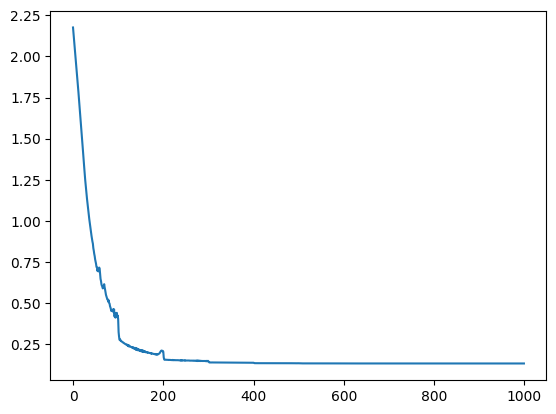

In [121]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [122]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.7494e-01, -1.6993e-06, -2.2844e-01, -1.7053e-01, -2.7922e-01,
         -1.6801e-01,  1.9739e-06, -2.0717e-07,  2.2138e-02, -3.2887e-06,
         -2.3656e-07, -1.6559e-06,  1.0906e-06, -1.6053e-06, -2.7959e-06,
         -4.1846e-07,  2.5643e-06, -1.7530e-06,  4.7824e-07, -2.5971e-06,
         -3.1015e-06,  3.6235e-07,  2.1856e-06, -2.1266e-06, -3.0166e-06,
          1.7242e-06,  2.1401e-07,  2.3849e-06,  7.8271e-07, -2.6966e-07,
          1.9945e-06,  1.4481e-06,  6.8617e-07,  2.2997e-06, -3.0178e-06,
          1.9516e-06, -1.2364e-06,  2.7602e-06,  3.2274e-07,  3.0311e-06,
          1.5637e-06,  2.8128e-06,  2.8922e-06, -2.5865e-06,  2.9495e-06,
          6.2348e-07,  6.6852e-02,  2.4950e-06,  1.7809e-06,  2.7669e-07,
         -2.2224e-07,  6.0753e-07, -3.4453e-06,  6.3636e-07, -6.1052e-07,
          5.7070e-06, -1.0295e-06,  3.5863e-06, -2.4227e-06, -1.4993e-06,
         -1.3788e-06,  2.4532e-06, -1.5327e-06,  2.2027e-06, -4.4128e-07,
          5.3866e-07, -2.3695e-06,  1.

tensor([[-1.7494e-01, -1.6993e-06, -2.2844e-01, -1.7053e-01, -2.7922e-01,
         -1.6801e-01,  1.9739e-06, -2.0717e-07,  2.2138e-02, -3.2887e-06,
         -2.3656e-07, -1.6559e-06,  1.0906e-06, -1.6053e-06, -2.7959e-06,
         -4.1846e-07,  2.5643e-06, -1.7530e-06,  4.7824e-07, -2.5971e-06,
         -3.1015e-06,  3.6235e-07,  2.1856e-06, -2.1266e-06, -3.0166e-06,
          1.7242e-06,  2.1401e-07,  2.3849e-06,  7.8271e-07, -2.6966e-07,
          1.9945e-06,  1.4481e-06,  6.8617e-07,  2.2997e-06, -3.0178e-06,
          1.9516e-06, -1.2364e-06,  2.7602e-06,  3.2274e-07,  3.0311e-06,
          1.5637e-06,  2.8128e-06,  2.8922e-06, -2.5865e-06,  2.9495e-06,
          6.2348e-07,  6.6852e-02,  2.4950e-06,  1.7809e-06,  2.7669e-07,
         -2.2224e-07,  6.0753e-07, -3.4453e-06,  6.3636e-07, -6.1052e-07,
          5.7070e-06, -1.0295e-06,  3.5863e-06, -2.4227e-06, -1.4993e-06,
         -1.3788e-06,  2.4532e-06, -1.5327e-06,  2.2027e-06, -4.4128e-07,
          5.3866e-07, -2.3695e-06,  1.

tensor([[-1.6924e-01,  1.6077e-07, -1.7519e-01, -1.0003e-01,  2.3854e-01,
         -1.7640e-01, -6.4021e-08, -4.4015e-07, -1.7186e-01, -2.8441e-07,
         -7.0283e-08, -7.4806e-09,  3.1535e-09,  7.4604e-07, -1.0863e-07,
          3.4199e-08, -8.1043e-07, -2.2259e-07,  2.2220e-09,  3.7552e-07,
          2.0440e-08,  9.8945e-08,  1.4626e-08,  2.0772e-07,  1.0739e-08,
         -1.6021e-08, -4.3921e-07, -2.4031e-08, -8.6835e-08,  3.3243e-11,
         -2.0096e-07, -1.9212e-07,  4.4944e-07,  2.6951e-08, -2.9537e-07,
         -1.6949e-07,  2.8892e-08,  3.2144e-08,  2.4881e-07, -1.0777e-07,
          5.0648e-08, -1.8527e-08, -1.6219e-07,  4.3831e-08, -1.2504e-07,
          3.1429e-08,  2.6187e-02, -8.9290e-09, -3.7591e-09, -4.5938e-09,
         -2.8871e-07,  1.9989e-09,  1.1379e-07,  9.1032e-08, -3.7238e-09,
          1.9194e-07, -7.2498e-09,  3.6376e-08,  3.3060e-07,  2.8676e-09,
          1.8725e-07, -1.2237e-08, -2.1011e-07,  8.9654e-07, -1.7578e-08,
          6.0939e-09, -3.7544e-08,  2.

(raylet) [2022-10-13 20:48:58,188 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 997679104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:49:08,194 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 997441536; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:49:18,202 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 997240832; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:49:28,209 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 996937728; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 20:54:08,408 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 984199168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:54:18,414 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 984010752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:54:28,422 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 983711744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:54:38,429 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 983552000; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 20:59:18,918 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 973189120; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:59:28,925 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 972926976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:59:38,931 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 972730368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:59:48,938 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 972431360; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:04:29,185 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 964694016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:04:39,194 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 963928064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:04:49,201 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 962662400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:04:59,208 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 961847296; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:09:39,527 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 933236736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:09:49,533 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 931901440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:09:59,554 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 930828288; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:10:09,561 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 930033664; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:14:49,855 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 901148672; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:14:59,867 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 900530176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:15:09,885 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 899440640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:15:19,891 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 898289664; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:20:00,224 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 869584896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:20:10,234 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 868655104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:20:20,239 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 867655680; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:20:30,243 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 866471936; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:25:10,532 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 837971968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:25:20,540 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 837005312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:25:30,545 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 835792896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:25:40,549 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 834912256; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:30:20,883 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 805924864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:30:30,888 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 804724736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:30:40,892 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 804061184; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:30:50,908 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 802607104; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:35:31,198 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 774074368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:35:41,203 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 773394432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:35:51,214 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 771932160; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:36:01,233 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 771088384; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-13 21:40:41,484 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 759214080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:40:51,491 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 758923264; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:41:01,499 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 758640640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 21:41:11,505 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 758472704; capacity: 29394726912. Object creation will fail i

In [117]:

model_1(test_x1)[0].squeeze()
model_2(test_x2)[0].squeeze()
model_3(test_x3)[0].squeeze()


tensor([0.2441, 0.2870, 0.9550, 0.0123, 0.0529, 0.0038, 0.0844, 0.9903, 0.2376,
        0.0100, 0.0102, 0.9330, 0.9865, 0.0425, 0.9857, 0.5562, 0.0228, 0.0034,
        0.9744, 0.1239, 0.0053, 0.1739, 0.9891, 0.2266, 0.9060, 0.0373, 0.4461,
        0.0154, 0.0064, 0.0243, 0.5838, 0.9883, 0.0496, 0.4592, 0.5365, 0.8561,
        0.0602, 0.0323, 0.7373, 0.0817], grad_fn=<SqueezeBackward0>)

tensor([4.5493e-01, 9.9878e-01, 7.7616e-03, 3.7248e-02, 9.8853e-01, 9.9080e-01,
        9.9264e-01, 9.7675e-01, 4.6552e-01, 4.7058e-02, 9.7913e-01, 9.9672e-01,
        6.8037e-01, 2.8468e-01, 9.9573e-01, 9.9752e-01, 6.7322e-01, 1.2096e-01,
        1.6419e-03, 9.8895e-01, 3.8688e-01, 3.5038e-01, 9.9730e-01, 3.5673e-02,
        1.6937e-03, 7.3361e-01, 9.8930e-01, 4.4495e-02, 1.6184e-04, 9.2214e-01,
        2.2114e-01, 9.9905e-01, 9.9963e-01, 8.9091e-07, 2.3977e-03, 9.9770e-01,
        9.5522e-01, 1.3389e-01, 9.9755e-01, 9.8497e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0.1811, 0.8381, 0.3345, 0.8459, 0.5170, 0.4750, 0.4713, 0.6612, 0.6755,
        0.5135, 0.2144, 0.7599, 0.8639, 0.5469, 0.4116, 0.8611, 0.6841, 0.5890,
        0.4586, 0.2204, 0.7711, 0.4509, 0.5605, 0.8022, 0.4035, 0.1568, 0.2407,
        0.3678, 0.6137, 0.4243, 0.5915, 0.3869, 0.8082, 0.4913, 0.6154, 0.5317,
        0.3354, 0.7846, 0.8499, 0.6524], grad_fn=<SqueezeBackward0>)

In [118]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[52, 12],
       [ 9, 47]])

0.8392857142857143

0.8125

0.825

0.7966101694915254

0.8173913043478261

In [119]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[24,  3],
       [ 2, 11]])

0.8461538461538461

0.8888888888888888

array([[12,  3],
       [ 6, 19]])

0.76

0.8

array([[16,  6],
       [ 1, 17]])

0.9444444444444444

0.7272727272727273

(raylet) [2022-10-13 20:46:28,084 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1001164800; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:46:38,090 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1000992768; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:46:48,097 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1000730624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:46:58,105 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1000542208; capacity: 29394726912. Object creation will fa

In [114]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.7097913e-01, -7.7510276e-07, -2.3386334e-01, -1.6142133e-01,
        -2.5948423e-01, -1.7038222e-01,  2.6915720e-06,  8.3308544e-07,
         2.1724686e-02, -1.2828338e-06, -2.9288249e-06,  1.6418676e-06,
        -2.9671430e-06, -1.6739754e-06, -1.4426425e-06, -1.7435245e-06,
         7.9830045e-07, -1.6216970e-06,  1.4140732e-06, -2.4450576e-06,
        -3.4763934e-06,  1.2296033e-06,  1.7198637e-06, -2.3873752e-06,
         1.1208789e-06,  2.3389026e-07,  2.5293180e-06, -1.7935939e-06,
        -3.4837640e-06,  3.2443161e-06,  2.9283854e-06,  1.8594479e-06,
         2.5520849e-06, -2.1301862e-06, -2.9750418e-06, -9.5539826e-07,
        -2.2629797e-06,  2.9588882e-06,  3.4696307e-06, -2.9832222e-06,
         1.2139061e-06,  1.6655852e-06, -2.4769254e-06, -2.2890109e-07,
         7.8006730e-07,  8.7573534e-07,  6.6131793e-02,  2.4020005e-06,
        -2.8758263e-06, -2.7389381e-06,  1.5578254e-06, -3.0081492e-06,
        -3.9607227e-07,  3.7015369e-07,  2.6015978e-06,  1.99825

array([[-1.7097913e-01, -7.7510276e-07, -2.3386334e-01, -1.6142133e-01,
        -2.5948423e-01, -1.7038222e-01,  2.6915720e-06,  8.3308544e-07,
         2.1724686e-02, -1.2828338e-06, -2.9288249e-06,  1.6418676e-06,
        -2.9671430e-06, -1.6739754e-06, -1.4426425e-06, -1.7435245e-06,
         7.9830045e-07, -1.6216970e-06,  1.4140732e-06, -2.4450576e-06,
        -3.4763934e-06,  1.2296033e-06,  1.7198637e-06, -2.3873752e-06,
         1.1208789e-06,  2.3389026e-07,  2.5293180e-06, -1.7935939e-06,
        -3.4837640e-06,  3.2443161e-06,  2.9283854e-06,  1.8594479e-06,
         2.5520849e-06, -2.1301862e-06, -2.9750418e-06, -9.5539826e-07,
        -2.2629797e-06,  2.9588882e-06,  3.4696307e-06, -2.9832222e-06,
         1.2139061e-06,  1.6655852e-06, -2.4769254e-06, -2.2890109e-07,
         7.8006730e-07,  8.7573534e-07,  6.6131793e-02,  2.4020005e-06,
        -2.8758263e-06, -2.7389381e-06,  1.5578254e-06, -3.0081492e-06,
        -3.9607227e-07,  3.7015369e-07,  2.6015978e-06,  1.99825

array([[-1.6494243e-01,  1.0199624e-07, -1.6641165e-01, -1.0501005e-01,
         2.2021547e-01, -1.7185263e-01, -1.7748874e-08, -9.1481559e-07,
        -1.6086829e-01, -6.5436927e-07, -2.6566481e-08, -1.9110672e-08,
         7.6544318e-09,  8.7805211e-07,  1.3897039e-07,  2.8360040e-08,
         7.4873505e-08, -2.8155884e-07, -1.6875611e-09, -1.3355297e-07,
         2.1953671e-08,  1.6854133e-07,  4.5407722e-09,  2.4345829e-07,
         9.1074117e-09, -1.1138323e-08, -1.8186098e-07, -1.2153440e-07,
         8.1590720e-08, -3.3625502e-09,  5.3163188e-07, -1.8162555e-07,
         6.0222163e-07, -2.5728690e-08, -1.5277267e-06, -2.5197625e-07,
         2.3107907e-08,  1.2498110e-08,  8.0566785e-08,  8.7797685e-07,
         8.8167127e-08,  1.6929883e-07,  9.8486890e-09,  4.6300128e-09,
         2.4691394e-08,  3.0791864e-07,  2.4455391e-02,  6.4695683e-07,
        -1.8283723e-08,  3.5721441e-09,  1.5528373e-08,  3.7438508e-07,
         1.5189226e-08, -2.5425162e-08, -7.3496614e-07,  1.22422

In [115]:
threshold=0.05
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.17097913,  0.        , -0.23386334, -0.16142133, -0.25948423,
        -0.17038222,  0.        ,  0.        ,  0.02172469,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.06613179,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  3,  4,  5,  6,  9, 47, 93])

8

(raylet) [2022-10-13 20:45:48,056 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1002143744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:45:58,062 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1001930752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:46:08,069 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1001680896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-13 20:46:18,076 E 30159 30194] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-13_19-54-58_234030_29874 is over 95% full, available space: 1001431040; capacity: 29394726912. Object creation will fa